## 2024S-T3 AML 3104 - Neural Networks and Deep Learning

Instructor: Ishant Gupta

Assigment: Sentiment Analysis Using Recurrent Neural Networks (RNN) with IMDB Dataset

Student: Antonio Carlos De Mello Mendes - c0866063@mylambton.ca

References:

1. TensorFlow. (2024). Text classification with TensorFlow Hub. TensorFlow.  Retrieved from https://www.tensorflow.org/tutorials/keras/text_classification_with_hub
2. TensorFlow. (2024). IMDB reviews dataset catalog. TensorFlow.  Retrieved from https://www.tensorflow.org/datasets/catalog/imdb_reviews

### IMDB Sentiment Analysis using RNN

Understanding Sentiment Analysis and RNNs:

Sentiment analysis is a powerful tool for understanding and interpreting emotional content in text, with numerous practical applications. Recurrent Neural Networks (RNNs) are designed to handle sequential data and maintain contextual information through hidden states. However, RNNs face challenges such as vanishing and exploding gradients, which can impact training and performance. Advanced RNN architectures like LSTM and GRU address these challenges by incorporating mechanisms to handle long-term dependencies and stabilize training.

In [1]:
# Install tensor flow datasets
!pip install tensorflow-datasets
!pip install nltk

In [2]:
# Loading libraries
import pandas as pd
import numpy as np
import re

# Loading Tensorflow libraries
import tensorflow as tf
import tensorflow_datasets as tfds

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for cleaning and preprocessing reviews
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Load the IMDB dataset as supervised (input, label) pairs
imdb_train, imdb_test = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)

# Convert the dataset to a list of tuples (text, label)
data_training = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in imdb_train]
data_test = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in imdb_test]

# Create a DataFrame from the list of tuples
df_imdb_train = pd.DataFrame(data_training, columns=['review', 'label'])
df_imdb_test = pd.DataFrame(data_test, columns=['review', 'label'])

# Concatenate dataframes
df_imdb = pd.concat([df_imdb_train, df_imdb_test])

# Display the first 5 rows
df_imdb.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZW7HOW_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZW7HOW_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZW7HOW_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


,review,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


### Text preprocessing

In [4]:
# Explore the dataset
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
# Data Preprocessing Functions

# Function for text cleaning
def clean_text(text):

    # Check if the text is a string
     if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z\s]", '', text)  # Remove special characters and digits
        text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
        text = re.sub(r"[^\w\s']", '', text)  # Remove punctuation
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.lower() # Convert to lowercase

        return text
     else:
        return ""

# Function for tokenize the words, remove stop words, and treat normalization
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalize words by using Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    text = ' '.join(tokens)
    return text

# Function for tokenize the words, remove stop words, and treat normalization
def preprocess_tokens(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalize words by using Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [6]:
# Cleaning and preprocessing the text from imdb

# Convert the review column to string
df_imdb['review'] = df_imdb['review'].astype(str)

# Remove punctuation, special characters, and numbers
df_imdb['review_cleaned'] = df_imdb['review'].apply(clean_text)

# Perform tokenize the words, remove stop words, and treat normalization
df_imdb['review_cleaned'] = df_imdb['review_cleaned'].apply(preprocess_text)

# Perform tokenize the words, remove stop words, and treat normalization using tokens as a result
df_imdb['tokens'] = df_imdb['review_cleaned'].apply(preprocess_tokens)

# Display the first 5 rows
df_imdb.head()

,review,label,review_cleaned,tokens
0,This was an absolutely terrible movie. Don't b...,0,absolutely terrible movie dont lured christoph...,"[absolutely, terrible, movie, dont, lured, chr..."
1,"I have been known to fall asleep during films,...",0,known fall asleep film usually due combination...,"[known, fall, asleep, film, usually, due, comb..."
2,Mann photographs the Alberta Rocky Mountains i...,0,mann photograph alberta rocky mountain superb ...,"[mann, photograph, alberta, rocky, mountain, s..."
3,This is the kind of film for a snowy Sunday af...,1,kind film snowy sunday afternoon rest world go...,"[kind, film, snowy, sunday, afternoon, rest, w..."
4,"As others have mentioned, all the women that g...",1,others mentioned woman go nude film mostly abs...,"[others, mentioned, woman, go, nude, film, mos..."


### Analyzing the distribuition of the words within the dataset

In [7]:
# Get a list of all words in the tokenized texts
all_words = [word for tokens in df_imdb["tokens"] for word in tokens]

# Get a list of text lengths in the tokenized texts
text_lengths = [len(tokens) for tokens in df_imdb["tokens"]]

# List all unique words in the dataset and sort them for future convenience
vocab = sorted(set(all_words))

# Print the total number of words and the vocabulary size
print(f'Total number of words: {len(all_words)}')
print(f'Vocabulary size: {len(vocab)}')

# Print the maximum sentence length
print(f'Max text length: {max(text_lengths)}')

Total number of words: 6060721
Vocabulary size: 164323
Max text length: 1436


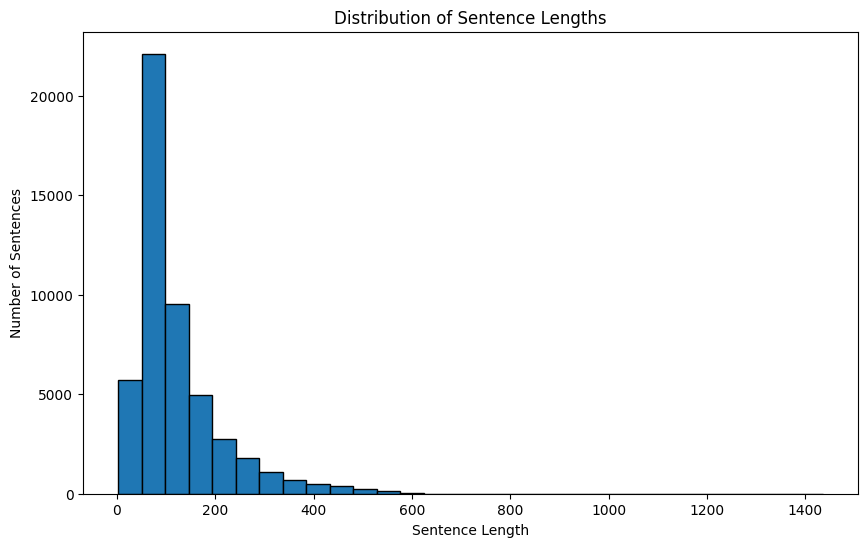

In [8]:
import matplotlib.pyplot as plt

# Define the figure size and create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the labels for the x and y axes
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Number of Sentences')

# Plot the histogram of sentence lengths
ax.hist(text_lengths, bins=30, edgecolor='black')

# Set the title for the plot
ax.set_title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

In [9]:
# Extract input as texts and labels
input_texts = df_imdb['review_cleaned'].values
labels = df_imdb['label'].values

In [10]:
# Check input variable
input_texts

array(['absolutely terrible movie dont lured christopher walken michael ironside great actor must simply worst role history even great acting could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel making case revolution maria conchita alonso appeared phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movie like ruining actor like christopher walkens good name could barely sit',
       'known fall asleep film usually due combination thing including really tired warm comfortable sette eaten lot however occasion fell asleep film rubbish plot development constant constantly slow boring thing seemed happen explanation causing admit may missed part film watched majority everything seemed happen accord without real concern anything else cant recommend film',
       'mann photograph alberta rocky mountain superb fashion jimmy stewart walter brennan give enjoyable performance always seem br 

In [11]:
# Tokenize the texts using keras
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(input_texts)
sequences = tokenizer.texts_to_sequences(input_texts)

In [12]:
# Padding the sequences to ensure uniform input length using keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post')

### Building the RNN Model

In [13]:
# Define model parameters
vocab_size = 10000
embedding_dim = 128
lstm_units = 64
num_classes = len(labels)

In [14]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
rnn_mdl = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_length, trainable = True), # Embedding layer
    Bidirectional(LSTM(lstm_units, return_sequences = True)), # RNN layer using LSTM
    Dropout(0.5), # Hidden Layer, connected with input layer
    Bidirectional(LSTM(lstm_units)), # RNN layer using LSTM
    Dense(64, activation='relu'), # Hidden Layer 1
    Dropout(0.5), # Hidden Layer 2
    Dense(num_classes, activation='softmax') # Output layer
])

In [15]:
# Compile the model with sparse categoricalcrossentropy loss function and Adam as optimizer
rnn_mdl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Adding early stopping to prevent overfitting and learning rate reduction on plateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # It is used to stop training early if the model’s performance on the validation set stops improving
reduce_lr_plu = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

### Training based on the RNN model built

In [ ]:
# Split the data into training and test sets using 20% for test and 80% for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size = 0.2, random_state = 42)

# Training the model using 10 epochs
history = rnn_mdl.fit(X_train, y_train, epochs=20, batch_size=64, callbacks=[early_stopping, reduce_lr_plu])

### Evaluating the Model

In [ ]:
# Evaluating the Model
test_predict = rnn_mdl.predict(X_test)
test_pred_classes = np.argmax(test_predict, axis=1)

In [ ]:
# Calculate the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, test_pred_classes.reshape(-1))

# Generate a classification report
report_test = classification_report(y_test, test_pred_classes.reshape(-1))

auc_test = roc_auc_score(y_test, test_pred_classes.reshape(-1), multi_class='ovo')

print("Test Data Classification Report:\n", report_test)
print("Test Data AUC: ", auc_test)

### Hyperparameter Tuning

In [21]:
# Take the first 5000 samples from X_train and y_train
X_train_reduced = X_train[:1000]
y_train_reduced = y_train[:1000]

In [22]:
# Using grid search cross-validation
# Load libraries
from sklearn.neural_network import MLPClassifier  # a class from scikit-learn used for training feedforward neural networks
from sklearn.model_selection import GridSearchCV # a class from scikit-learn used for perform th grid search and find the best parameters
from sklearn.metrics import classification_report # a class from scikit-learn used for reporting metrics

# Initialize the MLPClassifier
mlp_crf = MLPClassifier(max_iter=300, random_state=42)

# Define the parameter grid for the hyperparameters tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Different configurations for hidden layers
    'activation': ['tanh', 'relu'],                  # Activation functions to try
    'solver': ['sgd', 'adam'],                       # Optimization algorithms to test
    'alpha': [0.0001, 0.05],                         # Regularization parameter
    'learning_rate': ['constant', 'adaptive'],       # Learning rate schedule
}

# Initialize GridSearchCV (5=fold cross-validation, users all available processors for computation, prints detailed output during the search)
grd_cv = GridSearchCV(estimator=mlp_crf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2) # The estimator is based on MLPClassifier object

# Perform grid search and find out the best parameters
grd_cv.fit(X_train_reduced, y_train_reduced)

# Evaluate the top-performing model

# Display the optimal parameters
print(f"Best Parameters: {grd_cv.best_params_}")

# Make predictions on the test set using the optimal model
y_pred = grd_cv.best_estimator_.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
              precision    recall  f1-score   support

           0       0.51      0.63      0.56      5020
           1       0.51      0.38      0.43      4980

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



### Comparative Analysis

In [26]:
import tensorflow
opt_hyper = tensorflow.keras.optimizers.SGD(learning_rate=0.05) # It defined according to hyperparameters
loss = tensorflow.keras.losses.BinaryCrossentropy()
loss

In [27]:
# Build an ANN model according to hyperparameters tuning
ann_mdl = Sequential([
    Dense(50, activation = 'tanh', input_shape = (X_train.shape[1],)), # Hidden Layer 1, connected with input layer
    Dense(50, activation ='relu'), # Hidden Layer 2
    Dense(1, activation = 'sigmoid')  # Output layer is binary classification so that is sigmoid
]
)

In [28]:
# Compile the model
ann_mdl.compile(optimizer=opt_hyper, loss="binary_crossentropy", metrics=['accuracy'])

In [30]:
# Configure Early Stopping
e_stopping_callbac = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True) # It is used to stop training early if the model’s performance on the validation set stops improving

# Train the model
history=ann_mdl.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 50)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4997 - loss: 0.7072 - val_accuracy: 0.5067 - val_loss: 0.6933
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4953 - loss: 0.6950 - val_accuracy: 0.5065 - val_loss: 0.6936
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5060 - loss: 0.6933 - val_accuracy: 0.5114 - val_loss: 0.6926
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5005 - loss: 0.6933 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5117 - loss: 0.6929 - val_accuracy: 0.5125 - val_loss: 0.6927
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4995 - loss: 0.6932 - val_accuracy: 0.5110 - val_loss: 0.6929
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5015 - loss: 0.6933 - val_accuracy: 0.5119 - val_loss: 0.6929
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5015 - loss: 0.6932 - 

In [31]:
# Evaluating the Model
test_predict = ann_mdl.predict(X_test)
test_pred_classes = np.argmax(test_predict, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [32]:
# Calculate the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, test_pred_classes.reshape(-1))

# Generate a classification report
report_test = classification_report(y_test, test_pred_classes.reshape(-1))

auc_test = roc_auc_score(y_test, test_pred_classes.reshape(-1), multi_class='ovo')

print("Test Data Classification Report:\n", report_test)
print("Test Data AUC: ", auc_test)

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      5020
           1       0.00      0.00      0.00      4980

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.34     10000

Test Data AUC:  0.5
